In [1]:
%%capture
!pip install transformers[sentencepiece]
!pip install evaluate
!pip install tweet-preprocessor
!pip install contractions
!pip install autocorrect
!pip install swifter

In [2]:
import numpy as np
import pandas as pd
import swifter

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2

from datasets import Dataset, DatasetDict
from transformers import DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer,TFAutoModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
social=pd.read_csv('/kaggle/input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv',encoding='latin-1')
social=social[['keyword','location','text','choose_one']]
social=social[social['choose_one']!="Can't Decide"]
social['target']=(social['choose_one']=='Relevant').astype(int)
social.drop(columns=['choose_one'],inplace=True)

In [4]:
df_train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

df_train.drop(columns=['id'],inplace=True)
df_test.drop(columns=['id'],inplace=True)
df_train=pd.concat([social,df_train])
df_train.reset_index(drop=True, inplace=True)

df_train = df_train.dropna(subset=['text'], inplace=False)
df_train = df_train.drop_duplicates()
df_train.head()

,keyword,location,text,target
0,NaN,NaN,Just happened a terrible car crash,1
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [5]:
df_train.keyword=df_train.keyword.fillna("None")
df_train.location=df_train.location.fillna("None")

df_test.keyword=df_test.keyword.fillna("None")
df_test.location=df_test.location.fillna("None")

In [6]:
import preprocessor as clean_tweet
import re
from autocorrect import Speller
import contractions
from gensim.parsing.preprocessing import remove_stopwords
import swifter

spell = Speller(lang='en')
def clean_data(text):
#     x=clean_tweet.clean(text)
    x=re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text) # remove url
    x=re.sub(r'[^\w\s]', '', text) # remove puntuation
    x=re.sub(r'(.)\1+', r'\1', x) # loveeeeee to love
#     x=spell(x) # loev to love
    x=contractions.fix(x) # don't to do not
    x=remove_stopwords(x) # remove_stopwords
    return x

In [7]:
cols=['keyword','location','text']
for col in cols:
    df_train[col]=df_train[col].swifter.apply(clean_data)
    df_test[col]=df_test[col].swifter.apply(clean_data)

Pandas Apply:   0%|          | 0/10769 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10769 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/10769 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3263 [00:00<?, ?it/s]

In [8]:
# df_train.to_csv('clean_train.csv',index=False)
# df_test.to_csv('clean_test.csv',index=False)

In [9]:
tmp=list(map(lambda x: len(x.split()),df_train['text']))
max(tmp)

28

In [10]:
dataset_train=Dataset.from_pandas(df_train)
dataset_test=Dataset.from_pandas(df_test)
tmp_dataset_dict=DatasetDict({"train":dataset_train,"test":dataset_test})

dataset_dict = tmp_dataset_dict["train"].train_test_split(train_size=0.9,shuffle=False, seed=7)
dataset_dict["validation"] = dataset_dict.pop("test")
dataset_dict["test"] = tmp_dataset_dict["test"]

In [11]:
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['keyword', 'location', 'text', 'target', '__index_level_0__'],
        num_rows: 9692
    })
    validation: Dataset({
        features: ['keyword', 'location', 'text', 'target', '__index_level_0__'],
        num_rows: 1077
    })
    test: Dataset({
        features: ['keyword', 'location', 'text'],
        num_rows: 3263
    })
})


In [12]:
# checkpoint="bert-base-uncased"
checkpoint='vinai/bertweet-base'
# checkpoint='distilbert-base-uncased'
# checkpoint="cardiffnlp/twitter-roberta-base"
tokenizer=AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
# pretrained_model=TFAutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels = 2)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
def tokenize_function(datapoint):
    return tokenizer(datapoint["keyword"]+'. '+datapoint['location']+'. '+datapoint['text'], padding='longest',truncation=True,max_length=64)

tokenized_datasets = dataset_dict.map(tokenize_function, batched=False)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/9692 [00:00<?, ?ex/s]

  0%|          | 0/1077 [00:00<?, ?ex/s]

  0%|          | 0/3263 [00:00<?, ?ex/s]

In [14]:
pass_cols=["attention_mask", "input_ids", "token_type_ids"]
BATCH_SIZE=64

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=pass_cols,
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=pass_cols,
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=pass_cols,
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

In [15]:
history_df=pd.DataFrame()
pretrained_model=TFAutoModel.from_pretrained(checkpoint,from_pt=True)
pretrained_model.training=True
def build_model():
    
    input_ids = layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")
#     token_type_ids = layers.Input(shape=(None,), dtype=tf.int32, name="token_type_ids")


    seq = pretrained_model([input_ids,attention_mask]).last_hidden_state[:,0,:]
    seq=layers.BatchNormalization()(seq)
    seq = layers.Dropout(rate=0.3)(seq)
    
    seq = layers.Dense(128, activation='relu',kernel_regularizer=L2(0.05))(seq)
    seq=layers.BatchNormalization()(seq)
    seq = layers.Dropout(rate=0.2)(seq)

    seq = layers.Dense(32, activation='relu',kernel_regularizer=L2(0.05))(seq)
    seq=layers.BatchNormalization()(seq)
    seq = layers.Dropout(rate=0.1)(seq)

    seq = layers.Dense(8, activation='relu',kernel_regularizer=L2(0.05))(seq)
    seq=layers.BatchNormalization()(seq)
    out = layers.Dense(1, activation='sigmoid')(seq)
    
    model = tf.keras.models.Model(inputs=[input_ids,attention_mask], outputs=out)
    return model

model=build_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [16]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from keras.metrics import Precision, Recall

early_stopping=EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    restore_best_weights=True)

lr_scheduler = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=150,
    decay_rate=0.98,
    staircase=True
)

opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr_scheduler,beta_1=0.9, beta_2=0.98,epsilon=1e-9)
# opt = Adam(learning_rate=lr_scheduler)

# from transformers.keras_callbacks import PushToHubCallback
# callback = PushToHubCallback(output_dir="bert-finetuned-ner", tokenizer=tokenizer)

In [17]:
import gc
gc.collect()

23920

In [18]:
model.compile(optimizer=opt,
              loss=BinaryCrossentropy(from_logits=False),
              metrics=["accuracy"])
history=model.fit(tf_train_dataset,
          validation_data=tf_validation_dataset,
          callbacks=[early_stopping],
          epochs=30,verbose=1)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


151/151 [==============================] - 86s 444ms/step - loss: 14.6657 - accuracy: 0.6827 - val_loss: 14.3010 - val_accuracy: 0.8050
Epoch 2/30
151/151 [==============================] - 63s 415ms/step - loss: 14.0637 - accuracy: 0.7936 - val_loss: 13.7779 - val_accuracy: 0.8078
Epoch 3/30
151/151 [==============================] - 63s 416ms/step - loss: 13.5184 - accuracy: 0.8208 - val_loss: 13.2258 - val_accuracy: 0.8236
Epoch 4/30
151/151 [==============================] - 63s 415ms/step - loss: 12.9871 - accuracy: 0.8366 - val_loss: 12.8050 - val_accuracy: 0.7957
Epoch 5/30
151/151 [==============================] - 63s 414ms/step - loss: 12.4631 - accuracy: 0.8472 - val_loss: 12.2367 - val_accuracy: 0.8208
Epoch 6/30
151/151 [==============================] - 63s 417ms/step - loss: 11.9625 - accuracy: 0.8635 - val_loss: 11.7838 - val_accuracy: 0.8078
Epoch 7/30
151/151 [==============================] - 63s 414ms/step - loss: 11.4810 - accuracy: 0.8725 - val_loss: 11.2979 - val

minimum validation loss: 5.128032207489014


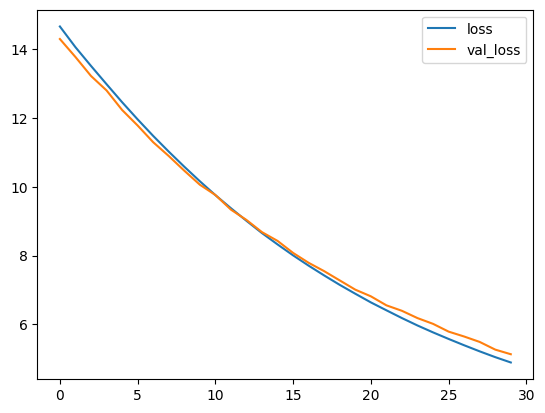

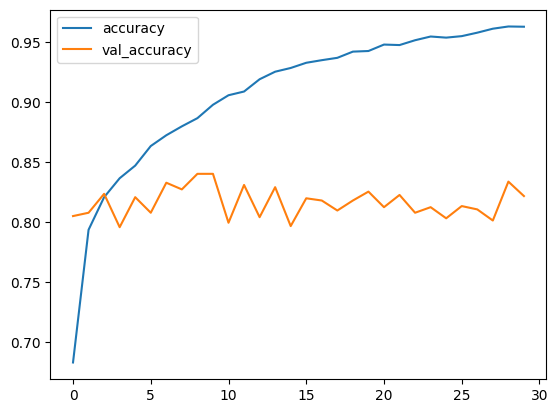

In [19]:
history_df=pd.concat([history_df,pd.DataFrame(history.history)],axis=1)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
print("minimum validation loss: {}".format(history_df['val_loss'].min()))

In [20]:
preds = model.predict(tf_validation_dataset)
# ["logits"]

/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/17 [==============================] - 6s 132ms/step


In [21]:
import evaluate

pred_label=list(map(lambda x: 1 if x>0.5 else 0,preds))

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=pred_label, references=dataset_dict["validation"]["target"])

{'accuracy': 0.8217270194986073, 'f1': 0.8110236220472441}

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

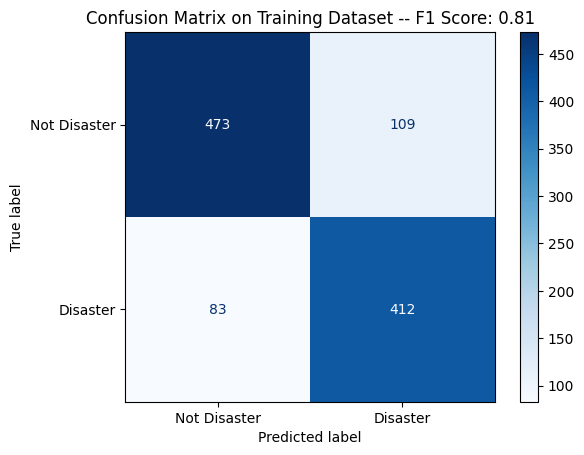

In [23]:
displayConfusionMatrix(dataset_dict['validation']['target'], pred_label, "Training")

In [24]:
preds = model.predict(tf_test_dataset)
sample_submission=pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission['target']=list(map(lambda x: 1 if x>0.5 else 0,preds))
sample_submission.to_csv("submission.csv",index=False)

/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


51/51 [==============================] - 11s 140ms/step
